In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.nn as nn
import lightning as L
from torchmetrics import MeanSquaredError
from torchinfo import summary
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

import optuna
import torch.optim as optim

from typing import List
from typing import Optional

/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("01_data_processing.ipynb.output/disease_rates_wide.csv")
df

,mmwr_week,Utah,Tennessee,Oregon,Ohio,New_York,New_Mexico,Minnesota,Michigan,Maryland,...,18-29_yr,12-17_yr,Male,Female,All,White_NH,Hispanic,Black_NH,American_Indian_Alaska_Native_NH,Asian_Pacific_Islander_NH
0,40.0,0.1,0.3,0.0,0.0,0.0,0.2,0.2,0.4,0.1,...,0.0,0.0,0.2,0.2,0.2,0.1,0.1,0.5,0.0,0.2
1,41.0,0.1,0.6,0.2,0.1,0.0,0.2,0.3,0.0,0.2,...,0.2,0.0,0.3,0.3,0.3,0.2,0.3,0.6,0.0,0.2
2,42.0,0.0,0.7,0.2,0.0,0.1,0.5,0.6,0.1,0.2,...,0.0,0.0,0.3,0.4,0.3,0.2,0.2,0.7,0.0,0.4
3,43.0,0.2,1.0,0.2,0.0,0.0,0.2,0.4,0.1,0.2,...,0.0,0.0,0.4,0.4,0.4,0.2,0.5,0.8,0.0,0.3
4,44.0,0.1,0.8,0.3,0.0,0.3,0.2,0.5,0.8,0.3,...,0.1,0.1,0.4,0.5,0.5,0.3,0.5,0.9,0.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,369.0,9.2,10.9,7.3,11.1,19.8,17.1,19.3,19.4,20.4,...,4.4,2.7,15.8,17.2,16.6,15.0,11.2,21.3,22.3,8.4
309,370.0,10.1,17.5,10.2,18.9,25.1,19.0,19.4,16.6,27.5,...,4.4,3.2,18.7,20.0,19.4,18.2,11.8,22.5,22.0,9.1
310,371.0,12.5,17.8,10.8,21.3,23.2,18.0,15.2,22.3,28.8,...,4.0,3.4,18.1,19.8,18.9,17.8,11.1,21.4,23.6,8.6
311,372.0,11.6,11.9,10.3,18.7,21.5,16.7,12.8,20.5,25.7,...,3.3,2.3,14.6,15.8,15.2,14.2,9.4,14.8,13.9,7.5


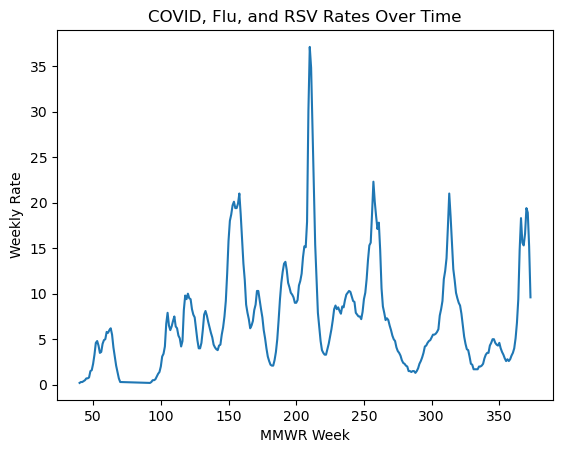

In [3]:
plt.plot(df['mmwr_week'], df['All'])
plt.title('COVID, Flu, and RSV Rates Over Time')
plt.xlabel('MMWR Week')
plt.ylabel('Weekly Rate')
plt.show()

In [4]:
#make a train, val, and test set
train = df[(df["mmwr_week"] >= 0) & (df["mmwr_week"] < 200)]#end of 2018, 2019, 2020. 2021
val = df[(df["mmwr_week"] >= 200) & (df["mmwr_week"] < 280)]#2022, 2023
test = df[(df["mmwr_week"] >= 280)]#2024, the start of 2025
train = train.drop('mmwr_week', axis=1)
val = val.drop('mmwr_week', axis=1)
test = test.drop('mmwr_week', axis=1)

In [5]:
from torch.utils.data import TensorDataset

def timeseries_dataset_from_array(sequence, targets, sequence_length, start_index=0, end_index=None):
    X, y = [], []
    end_index = (len(sequence) - sequence_length) if end_index is None else end_index
    for i in range(start_index, end_index):
        X.append(sequence[i: i + sequence_length])
        y.append(targets[i])

    return torch.from_numpy(np.array(X)).float(), torch.from_numpy(np.array(y)).float()


#create each dataset
sequence_length=10
ds_train = TensorDataset(*timeseries_dataset_from_array(
    train.values,
    train[['All']].values,
    sequence_length))

ds_val = TensorDataset(*timeseries_dataset_from_array(
    val.values,
    val[['All']].values,
    sequence_length))

ds_test = TensorDataset(*timeseries_dataset_from_array(
    test.values,
    test[['All']].values,
    sequence_length))

len(ds_train), len(ds_val), len(ds_test)

(129, 70, 84)

In [6]:
from torch.utils.data import DataLoader

dl_train = DataLoader(ds_train, batch_size=5, num_workers=2, shuffle=True,
                      persistent_workers=True, drop_last=True, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=5, num_workers=2, shuffle=False,
                    persistent_workers=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=5, num_workers=2, shuffle=False,
                     persistent_workers=True, pin_memory=True)

In [7]:
class BaseForecaster(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr

        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()
        
    def forward(self, x):
        pass

    def _common_step(self, batch, batch_idx, metric, loss_lbl, metric_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.mse_loss(logits, y)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(metric_lbl, metric(logits, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_mse, "loss", "mse")

    def on_training_epoch_end(self):
        self.log("mse", self.train_mse.compute())
        self.train_mse.reset()

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_mse, "val_loss", "val_mse")

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_mse.compute())
        self.val_mse.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_mse, "test_loss", "test_mse")

    def on_test_epoch_end(self):
        self.log("test_mse", self.test_mse.compute())
        self.test_mse.reset()

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=self.lr)

In [8]:
# class RNNForecaster(BaseForecaster):
#     def __init__(self, lr=0.001, sequence_length=10):
#         super().__init__(lr)
#         self.sequence_length = sequence_length

#         self.rnn1 = nn.RNN(input_size=39, hidden_size=200, batch_first=True)
#         self.rnn2 = nn.RNN(input_size=200, hidden_size=100, batch_first=True)
#         self.linear = nn.Sequential(
#             nn.Linear(1000, 50),
#             nn.ReLU()
#         )
#         self.out = nn.Linear(50, 1)
#         self.flatten = nn.Flatten()

#     def forward(self, x):
#         x = x.view(-1, self.sequence_length, 39)
#         o, _ = self.rnn1(x)
#         o, _ = self.rnn2(o)
#         o = self.flatten(o)
#         o = self.linear(o)
#         return self.out(o)

# rnn_model = RNNForecaster(sequence_length=10)
# summary(rnn_model)

In [9]:
# logger = CSVLogger("logs", name="rnn")

# trainer = L.Trainer(max_epochs=100, callbacks=[
#     ModelCheckpoint(
#         monitor='val_loss', mode='min', save_last=True, save_top_k=1,
#         dirpath='checkpoints/', filename='rnn-{epoch:02d}-{val_loss:.2f}',
#     ),
#     EarlyStopping(monitor='val_loss', patience=10, mode='min')
# ], logger=logger, enable_progress_bar = False,log_every_n_steps=3)
# trainer.fit(rnn_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

In [10]:
# hist = pd.read_csv(f"./logs/rnn/version_{len(os.listdir('./logs/rnn/')) - 1}/metrics.csv")
# hist[['mse', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
#                                          grid=True, title="Training Curves")
# hist[['val_mse', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
#                                          grid=True, title="Validation Curves")


In [11]:
class LSTMForecaster(BaseForecaster):
    def __init__(self,hidden_size1=200,hidden_size2=200,hidden_size3=200, lr=0.001, sequence_length=10):
        super().__init__(lr)
        self.sequence_length = sequence_length
        self.lstm1 = nn.LSTM(input_size=39, hidden_size=hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2, batch_first=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(hidden_size2*self.sequence_length, hidden_size3),
            nn.ReLU()
        )
        self.out = nn.Linear(hidden_size3, 1)

    def forward(self, x):
        x = x.view(-1, self.sequence_length, 39)
        o, _ = self.lstm1(x)
        o, _ = self.lstm2(o)
        o = self.flatten(o)
        o = self.linear(o)
        return self.out(o)


In [12]:
def objective(trial):
    # Hyperparameters to tune
    hidden_size1 = trial.suggest_int('hidden_size1', 32, 512)
    hidden_size2 = trial.suggest_int('hidden_size2', 32, 512)
    hidden_size3 = trial.suggest_int('hidden_size3', 32, 512)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    

    model = LSTMForecaster(hidden_size1,hidden_size2,hidden_size3)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop 
    model.train()
    for epoch in range(20):
        for batch_idx, (data, target) in enumerate(dl_train):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return loss.item()

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best Hyperparameters:", study.best_params)

[I 2025-04-21 11:33:29,668] A new study created in memory with name: no-name-bf68d05c-547e-40eb-8d7b-8fef3bcdc47c
[I 2025-04-21 11:33:49,238] Trial 0 finished with value: 0.07514862716197968 and parameters: {'hidden_size1': 369, 'hidden_size2': 272, 'hidden_size3': 254, 'lr': 6.391936470516353e-05}. Best is trial 0 with value: 0.07514862716197968.
[I 2025-04-21 11:34:10,329] Trial 1 finished with value: 0.2448250949382782 and parameters: {'hidden_size1': 382, 'hidden_size2': 287, 'hidden_size3': 137, 'lr': 0.0028789612240200336}. Best is trial 0 with value: 0.07514862716197968.
[I 2025-04-21 11:34:36,827] Trial 2 finished with value: 0.4666716456413269 and parameters: {'hidden_size1': 178, 'hidden_size2': 459, 'hidden_size3': 426, 'lr': 0.0021600459002642652}. Best is trial 0 with value: 0.07514862716197968.
[I 2025-04-21 11:34:46,579] Trial 3 finished with value: 0.3162929117679596 and parameters: {'hidden_size1': 219, 'hidden_size2': 190, 'hidden_size3': 277, 'lr': 0.0027059206888469

Best Hyperparameters: {'hidden_size1': 401, 'hidden_size2': 167, 'hidden_size3': 263, 'lr': 0.0001125174026020868}


In [14]:
lstm_model = LSTMForecaster(sequence_length=10,hidden_size1=study.best_params['hidden_size1'],hidden_size2=study.best_params['hidden_size2'],lr=study.best_params['lr'])
summary(lstm_model)

Layer (type:depth-idx)                   Param #
LSTMForecaster                           --
├─MeanSquaredError: 1-1                  --
├─MeanSquaredError: 1-2                  --
├─MeanSquaredError: 1-3                  --
├─LSTM: 1-4                              708,968
├─LSTM: 1-5                              380,760
├─Flatten: 1-6                           --
├─Sequential: 1-7                        --
│    └─Linear: 2-1                       334,200
│    └─ReLU: 2-2                         --
├─Linear: 1-8                            201
Total params: 1,424,129
Trainable params: 1,424,129
Non-trainable params: 0

In [18]:

logger = CSVLogger("logs", name="lstm")

trainer = L.Trainer(max_epochs=100, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1,
        dirpath='checkpoints/', filename='lstm-{epoch:02d}-{val_loss:.2f}',
    ),
    EarlyStopping(monitor='val_loss', patience=10, mode='min')
], logger=logger, enable_progress_bar = False)
trainer.fit(lstm_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /uufs/chpc.utah.edu/common/home/u1159162/deep_learning_class/BMI6114-DL-Final-Project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | train_mse | MeanSquaredError | 0     
1 | val_mse   | MeanSquaredError | 0     
2 | test_mse  | MeanSquaredError | 0     
3 | lstm1     | LSTM             | 708 K 
4 | lstm2     | LSTM             | 380 K 
5 | flatten   | Flatten          | 0     
6 | linear    | Sequential       | 334 K 
7 | out       | Linear           | 201   
-----------------------------------------------
1.4 M     Trainable params
0         Non-trainab

array([[<Axes: >, <Axes: >]], dtype=object)

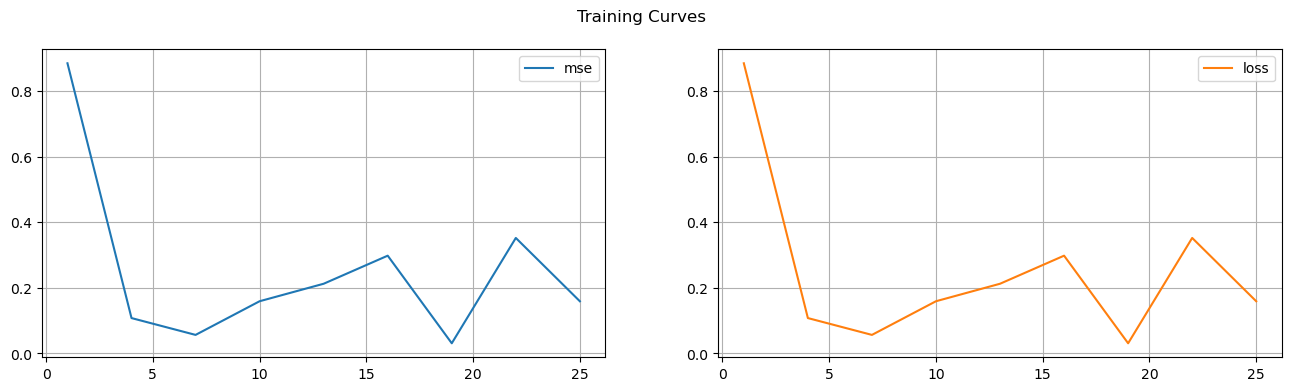

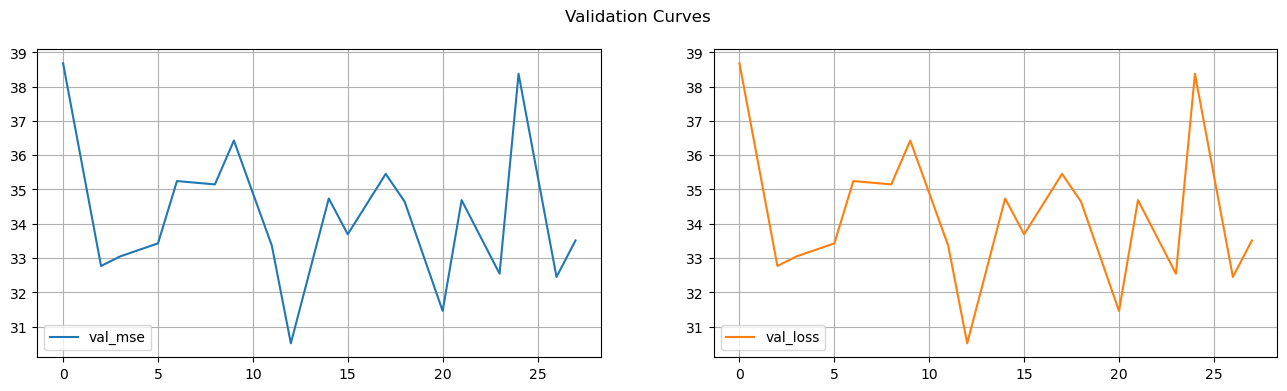

In [19]:
hist = pd.read_csv(f"./logs/lstm/version_{len(os.listdir('./logs/lstm/')) - 1}/metrics.csv")
hist[['mse', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves")
hist[['val_mse', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

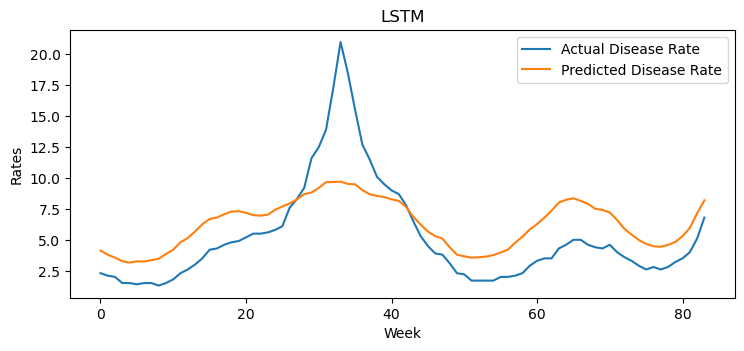

In [20]:
def plot_actual_vs_predicted(model, ds, label,sbplot_coord_1,sbplot_coord_2,sbplot_coord_3):
    
    y = ds.tensors[1]
    y_hat = model(ds.tensors[0]).detach()
    
    pd.DataFrame(torch.concat((y, y_hat), axis=1),
        columns=["Actual Disease Rate", "Predicted Disease Rate"]).plot(
        xlabel="Week", ylabel="Rates",ax=plt.subplot(sbplot_coord_1,sbplot_coord_2,sbplot_coord_3))

    plt.title(f"{label}")

fig = plt.figure(figsize=(18,8))
#plot_actual_vs_predicted(rnn_model, ds_test, "RNN", 2, 2, 1)
plot_actual_vs_predicted(lstm_model, ds_test, "LSTM", 2, 2, 1)
plt.subplots_adjust(wspace=0.1, hspace=0.3) 
plt.show()

In [29]:
## CROSS VALIDATION
from sklearn.model_selection import KFold
from torch.utils.data import Subset

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the dataset into 5 folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(train)):
    print(f"Fold {fold}:")
    print(f"Train indices: {train_idx[:5]}")
    print(f"Validation indices: {val_idx[:5]}")

    # Create subsets for training and validation
    train_subset = Subset(train, train_idx)
    val_subset = Subset(train, val_idx)

    print(f"Train subset size: {len(train_subset)}, Validation subset size: {len(val_subset)}")

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)

    
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    for batch_idx, (data, target) in enumerate(dl_train):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f"Training Loss: {loss.item()}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            val_loss += loss_fn(outputs, targets).item()

# Training example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cross_val_model = LSTMForecaster(sequence_length=10,hidden_size1=study.best_params['hidden_size1'],hidden_size2=study.best_params['hidden_size2'],lr=study.best_params['lr'])
optimizer = torch.optim.Adam(cross_val_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 10
for epoch in range(epochs):
    train_one_epoch(cross_val_model, train_loader, optimizer, criterion, device)
    torch.save(cross_val_model.state_dict(), f'model_fold_{fold}.pth')
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_loader)}")

Fold 0:
Train indices: [0 1 2 3 5]
Validation indices: [ 4 11 12 19 26]
Train subset size: 111, Validation subset size: 28
Fold 1:
Train indices: [1 2 3 4 5]
Validation indices: [ 0 10 15 16 18]
Train subset size: 111, Validation subset size: 28
Fold 2:
Train indices: [0 1 2 3 4]
Validation indices: [ 5  7  8  9 13]
Train subset size: 111, Validation subset size: 28
Fold 3:
Train indices: [0 1 2 4 5]
Validation indices: [ 3  6 17 38 41]
Train subset size: 111, Validation subset size: 28
Fold 4:
Train indices: [0 3 4 5 6]
Validation indices: [ 1  2 14 20 21]
Train subset size: 112, Validation subset size: 27
Training Loss: 6.821140289306641


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 364, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 364, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/pandas/core/frame.py", line 3893, in __getitem__
    indexer = self.columns.get_loc(key)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3798, in get_loc
    raise KeyError(key) from err
KeyError: 1


In [32]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

def cross_validate(model_class, dataset, k_folds, epochs, batch_size, device):
    results = {}
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")
        
        # Create data loaders for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss, optimizer
        model = model_class(sequence_length=10,hidden_size1=study.best_params['hidden_size1'],hidden_size2=study.best_params['hidden_size2'],lr=study.best_params['lr'])
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = torch.nn.MSELoss()

        for epoch in range(epochs):
            # Training phase
            model.train()
            for batch in train_loader:
                inputs, targets = batch[0], batch[1]
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    inputs, targets = batch[0], batch[1]
                    outputs = model(inputs)
                    val_loss += loss_fn(outputs, targets).item()

            print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_loader)}")

        # Save results for this fold
        results[fold] = val_loss / len(val_loader)
        torch.save(model.state_dict(), f'model_fold_{fold}.pth')

    print(f"Cross-validation results: {results}")
    return results
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cross_validate(LSTMForecaster, train, 5, 20, 5, device)

Fold 1/5


KeyError: 32